In [413]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors
import statsmodels.api as sm
import plotly.express as px
import squarify
import matplotlib.patches as mpatches
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Cargar Geopandas

In [495]:
# Ruta al archivo GeoJSON
archivo_geojson = "divisions-administratives-v2r1-municipis-1000000-20240705.json"

# Cargar el archivo GeoJSON en un GeoDataFrame
municipios = gpd.read_file(archivo_geojson)

# Establecer la columna 'geometry' como la columna activa de geometría
municipios = municipios.set_geometry("geometry")

# Cargar Datos de Renta Media por municipio

In [496]:
# Abrir y cargar el archivo de texto
archivo_txt = "renta.txt"

# Cargar el archivo como DataFrame
renta = pd.read_csv(
    archivo_txt, 
    sep=r'\t+',  # Usar tabulaciones como delimitadores
    engine='python',  # Motor Python para mayor flexibilidad
    names=["CodigoMunicipio", "Extranjeros de países de renta baja o media (%)", "Renta media por persona (€)"],
    skiprows=2  # Saltar las líneas iniciales de encabezado
)

# Separar el código y el municipio usando un enfoque más flexible
renta['Codigo'] = renta['CodigoMunicipio'].str.extract(r'(\d{5})')  # Extraer los 5 primeros dígitos como código
renta['Municipio'] = renta['CodigoMunicipio'].str.replace(r'\d{5}\s+', '', regex=True)  # Eliminar el código del texto para obtener el municipio

# Eliminar la columna original combinada
renta = renta.drop(columns=["CodigoMunicipio"])


# Reordenar las columnas
renta = renta[["Codigo", "Municipio", "Extranjeros de países de renta baja o media (%)", "Renta media por persona (€)"]]

# Eliminar cualquier código dentro de corchetes en la columna "Municipio"
renta['Municipio'] = renta['Municipio'].str.replace(r'\[\d+\]\s*', '', regex=True)

# Correspondencia entre renta y municipios

In [497]:
# Verificar si hay valores NaN en la columna "Renta media por persona (€)"
nan_rows = renta[renta['Renta media por persona (€)'].isna()]

if not nan_rows.empty:
    print("\n❌ Hay valores NaN de Renta. Detalles:")
    print(nan_rows[['Codigo', 'Municipio']])
else:
    print("\n✔️ No hay valores NaN de Renta para ningún municipio")


# Crear las columnas truncadas en ambos DataFrames
renta['Codigo_trunc'] = renta['Codigo'].str[:5]
municipios['CODIMUNI_trunc'] = municipios['CODIMUNI'].str[:5]


# Comprobar duplicados en renta
duplicados_renta = renta['Codigo_trunc'].value_counts()
duplicados_renta = duplicados_renta[duplicados_renta > 1]

# Comprobar duplicados en municipios
duplicados_municipios = municipios['CODIMUNI_trunc'].value_counts()
duplicados_municipios = duplicados_municipios[duplicados_municipios > 1]

# Buscar códigos en renta que no están en municipios
unmatched_renta = renta[~renta['Codigo_trunc'].isin(municipios['CODIMUNI_trunc'])]

# Buscar códigos en municipios que no están en renta
unmatched_municipios = municipios[~municipios['CODIMUNI_trunc'].isin(renta['Codigo_trunc'])]


print("\n Comprobación de correspondencia 1 a 1 entre renta y municipios:\n")

# Duplicados en renta
if duplicados_renta.empty:
    print("✔️ No hay códigos duplicados en renta.")
else:
    print("❌ Hay códigos duplicados en renta. Detalles:")
    print(duplicados_renta)

# Duplicados en municipios
if duplicados_municipios.empty:
    print("\n✔️ No hay códigos duplicados en municipios.")
else:
    print("\n❌ Hay códigos duplicados en municipios. Detalles:")
    print(duplicados_municipios)

# Códigos no encontrados en renta
if unmatched_renta.empty:
    print("\n✔️ Todos los códigos en renta tienen correspondencia en municipios.")
else:
    print("\n❌ Hay códigos en renta sin correspondencia en municipios. Detalles:")
    print(unmatched_renta[['Codigo', 'Municipio', 'Codigo_trunc']])

# Códigos no encontrados en municipios
if unmatched_municipios.empty:
    print("\n✔️ Todos los códigos en municipios tienen correspondencia en renta.")
else:
    print("\n❌ Hay códigos en municipios sin correspondencia en renta. Detalles:")
    print(unmatched_municipios[['CODIMUNI', 'NOMMUNI', 'CODIMUNI_trunc']])



❌ Hay valores NaN de Renta. Detalles:
    Codigo  Municipio
799  17194   Susqueda
859  17014  Vajol, la

 Comprobación de correspondencia 1 a 1 entre renta y municipios:

✔️ No hay códigos duplicados en renta.

✔️ No hay códigos duplicados en municipios.

✔️ Todos los códigos en renta tienen correspondencia en municipios.

✔️ Todos los códigos en municipios tienen correspondencia en renta.


# Mapa renta

In [5]:
# Crear las columnas truncadas en ambos DataFrames
renta['Codigo_trunc'] = renta['Codigo'].str[:5]
municipios['CODIMUNI_trunc'] = municipios['CODIMUNI'].str[:5]


merge1 = pd.merge(
    municipios,
    renta,
    left_on='CODIMUNI_trunc',  # Usamos el código truncado en municipios
    right_on='Codigo_trunc',   # Usamos el código truncado en renta
    how='inner'                # Sabemos que hay correspondencia 1 a 1
)

merge1.head()


,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry,CODIMUNI_trunc,Codigo,Municipio,Extranjeros de países de renta baja o media (%),Renta media por persona (€),Codigo_trunc
0,080018,Abrera,Abrera,19.9781,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5...",08001,08001,Abrera,"5,7",15134.0,08001
1,080023,Aguilar de Segarra,Aguilar de Segarra,43.2198,07,Bages,Manresa,07,Catalunya Central,*,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.61829 41.76885, 1.61278 41.7...",08002,08002,Aguilar de Segarra,"0,0",16275.0,08002
2,080039,Alella,Alella,9.6346,21,Maresme,Mataró,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"MULTIPOLYGON (((2.28512 41.51534, 2.28501 41.5...",08003,08003,Alella,"5,8",20889.0,08003
3,080044,Alpens,Alpens,13.7788,43,Lluçanès,Prats de Lluçanès,07,Catalunya Central,*,08,Barcelona,Barcelona,"MULTIPOLYGON (((2.09411 42.14192, 2.09031 42.1...",08004,08004,Alpens,"5,9",17081.0,08004
4,080057,l'Ametlla del Vallès,l'Ametlla del Vallès,14.0885,41,Vallès Oriental,Granollers,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"MULTIPOLYGON (((2.24126 41.70273, 2.24178 41.7...",08005,08005,"Ametlla del Vallès, l'","2,9",19464.0,08005


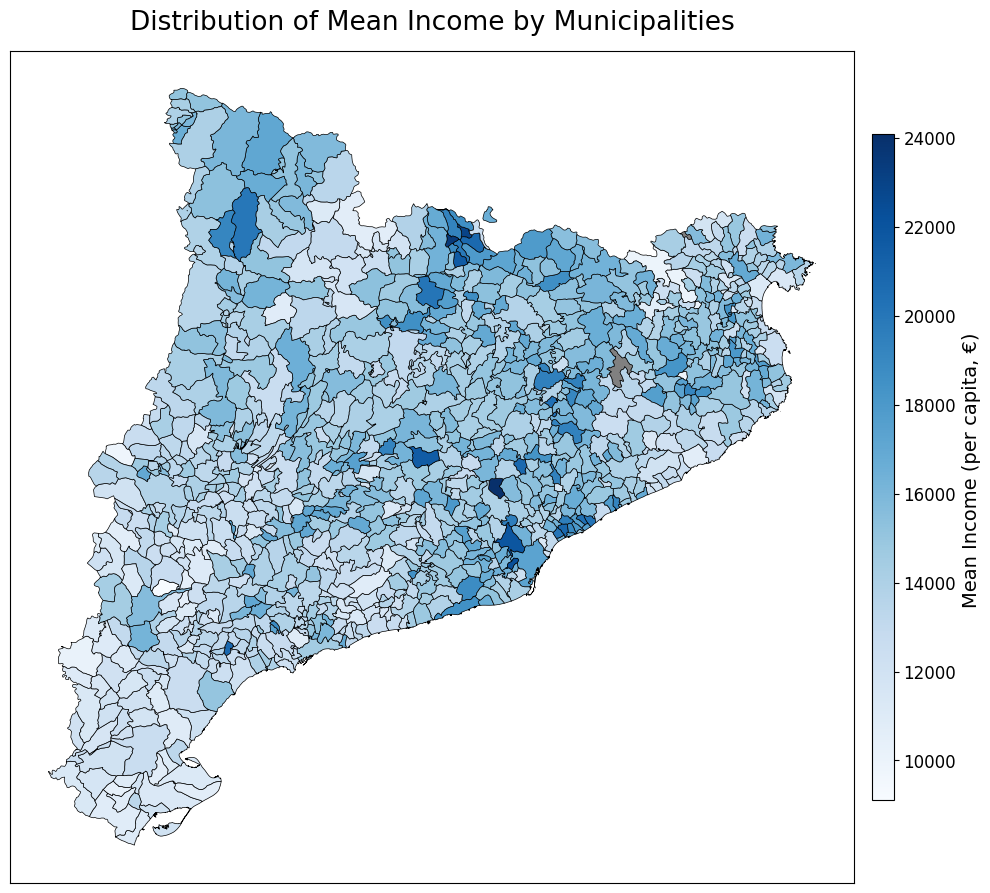

In [498]:
# Crear una nueva columna para asignar colores
merge1['color'] = np.where(
    merge1['Renta media por persona (€)'].isna(),
    'lightgrey',  # Color gris para valores NaN
    None     # Usaremos el cmap para los valores válidos
)

# Crear el gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Graficar municipios con valores de renta NaN en gris
merge1[merge1['Renta media por persona (€)'].isna()].plot(
    color='grey',
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    label='Sin datos'
)

# Graficar municipios con valores válidos de renta
merge1[~merge1['Renta media por persona (€)'].isna()].plot(
    column='Renta media por persona (€)',
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "Renta media por persona (€)",
        'shrink': 0.7,  # Reducir el tamaño de la barra
        'orientation': 'vertical',
        'fraction': 0.03,  # Controlar la longitud de la barra
        'pad': 0.02,      # Separación con el mapa
        'aspect': 30,     # Cambiar proporción de la barra
    }
)

# Cambiar el tamaño de la fuente de la leyenda de la barra de colores
cbar = ax.get_figure().get_axes()[-1]  # Acceder al último objeto de los ejes, que es la colorbar
cbar.set_ylabel('Mean Income (per capita, €) ', size=14)  # Cambiar el tamaño de la etiqueta
cbar.tick_params(labelsize=12)  # Cambiar el tamaño de los ticks

# Añadir título
ax.set_title("Distribution of Mean Income by Municipalities", fontsize=19, pad=15)

# Quitar ticks de los ejes
ax.set_xticks([])
ax.set_yticks([])

# Ajustar el layout
plt.tight_layout()

# Mostrar el mapa
plt.show()


# Cargar Datos de inmigrantes por municipio

In [499]:
poblacion_inmigrantes = pd.read_csv("inmigrantes_buenos.csv", sep=",", encoding="utf-8"  # Interpretar comas como separadores de miles
)

# Cambiar nombre de la columna "Municipio" a "Nombre_municipio"
poblacion_inmigrantes.rename(columns={'Municipio': 'Nombre_municipio'}, inplace=True)

# Separar la columna "Nombre_Municipio" en "Codigo" y "Municipio" considerando los corchetes
poblacion_inmigrantes[['Codigo', 'Municipio']] = poblacion_inmigrantes['Nombre_municipio'].str.extract(r'\[(\d+)\]\s*(.+)')

# Eliminar columna "Nombre_Municipio"
poblacion_inmigrantes = poblacion_inmigrantes.drop(columns=["Nombre_municipio"])

# Mover las nuevas columnas al principio del DataFrame
columnas_ordenadas = ['Codigo', 'Municipio'] + [
    col for col in poblacion_inmigrantes.columns if col not in ['Codigo', 'Municipio']
]
poblacion_inmigrantes = poblacion_inmigrantes[columnas_ordenadas]

# Eliminar la fila 0 del DataFrame
poblacion_inmigrantes = poblacion_inmigrantes.iloc[1:].reset_index(drop=True)


poblacion_inmigrantes['Codigo_trunc'] = poblacion_inmigrantes['Codigo'].str[:5]
print(len(poblacion_inmigrantes))

# Mostrar las primeras filas del DataFrame actualizado
poblacion_inmigrantes.head()

946


,Codigo,Municipio,Porcentaje pob española,prop no española,Codigo_trunc
0,080018,Abrera,93.4,0.066,08001
1,250024,Àger,87.6,0.124,25002
2,250030,Agramunt,82.7,0.173,25003
3,080023,Aguilar de Segarra,97.9,0.021,08002
4,170010,Agullana,82.6,0.174,17001


# Correspondencia entre población extranjera y municipios

In [500]:
# Verificar si hay valores NaN en la columna "Renta media por persona (€)"
nan_rows = poblacion_inmigrantes[poblacion_inmigrantes['prop no española'].isna()]

if not nan_rows.empty:
    print("\n❌ Hay valores NaN de Proporcion de inmigrantes. Detalles:")
    print(nan_rows[['Codigo', 'Municipio']])
else:
    print("\n✔️ No hay valores NaN de Proporcion de inmigrantes para ningún municipio")


# Comprobar duplicados en la columna "Codigo" de población_inmigrantes válidos
duplicados_poblacion_inmigrantes = poblacion_inmigrantes[poblacion_inmigrantes["Codigo"].duplicated(keep=False)]


# Comprobar correspondencia 1 a 1 entre los códigos
# Buscar códigos en poblacion_inmigrantes que no están en municipios
unmatched_inmigrantes = poblacion_inmigrantes[~poblacion_inmigrantes["Codigo_trunc"].isin(municipios["CODIMUNI_trunc"])]


# Buscar códigos en municipios que no están en poblacion_inmigrantes
unmatched_municipios = municipios[~municipios['CODIMUNI_trunc'].isin(poblacion_inmigrantes['Codigo_trunc'])]


print("\n Comprobación de correspondencia 1 a 1 entre población_inmigrantes y municipios:\n")

# Duplicados en población_inmigrantes
if duplicados_poblacion_inmigrantes.empty:
    print("✔️ No hay códigos duplicados en población_inmigrantes.")
else:
    print("❌ Hay códigos duplicados en población_inmigrantes. Detalles:")
    print(duplicados_poblacion_inmigrantes)

    
# Códigos en población_inmigrantes no encontrados en municipios
if unmatched_inmigrantes.empty:
    print("\n✔️ Todos los códigos en población_inmigrantes tienen correspondencia en municipios.")
else:
    print("\n❌ Hay códigos en población_inmigrantes sin correspondencia en municipios. Detalles:")
    print(unmatched_inmigrantes[["Código", "Municipio"]])

# Códigos en municipios no encontrados en población_inmigrantes
if unmatched_municipios.empty:
    print("\n✔️ Todos los códigos en municipios tienen correspondencia en población_inmigrantes.")
else:
    print("\n❌ Hay códigos en municipios sin correspondencia en población_inmigrantes. Detalles:")
    print(unmatched_municipios[['CODIMUNI', 'NOMMUNI', 'CODIMUNI_trunc']])


✔️ No hay valores NaN de Proporcion de inmigrantes para ningún municipio

 Comprobación de correspondencia 1 a 1 entre población_inmigrantes y municipios:

✔️ No hay códigos duplicados en población_inmigrantes.

✔️ Todos los códigos en población_inmigrantes tienen correspondencia en municipios.

❌ Hay códigos en municipios sin correspondencia en población_inmigrantes. Detalles:
    CODIMUNI             NOMMUNI CODIMUNI_trunc
532   250019  Abella de la Conca          25001


# Mapa inmigrantes

In [501]:
merge2 = municipios.merge(
    poblacion_inmigrantes,
    left_on='CODIMUNI_trunc',  # Clave en municipios
    right_on='Codigo_trunc',  # Clave en poblacion_inmigrantes
    how='left'  # Mantener todos los municipios (incluso si no hay datos en poblacion_inmigrantes)
)


In [ ]:
# Crear una nueva columna para asignar colores
merge2['color'] = np.where(
    merge2['prop no española'].isna(),
    'lightgrey',  # Color gris para valores NaN
    None     # Usaremos el cmap para los valores válidos
)

# Crear el gráfico
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Graficar municipios con valores de renta NaN en gris
merge2[merge2['prop no española'].isna()].plot(
    color='grey',
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    label='Sin datos'
)

# Graficar municipios con valores válidos de renta
merge2[~merge2['prop no española'].isna()].plot(
    column='prop no española',
    cmap='YlOrBr',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "Proportion of Foreign Population",
        'shrink': 0.7,  # Reducir el tamaño de la barra
        'orientation': 'vertical',
        'fraction': 0.03,  # Controlar la longitud de la barra
        'pad': 0.02,      # Separación con el mapa
        'aspect': 30,     # Cambiar proporción de la barra
    }
)

# Cambiar el tamaño de la fuente de la leyenda de la barra de colores
cbar = ax.get_figure().get_axes()[-1]  # Acceder al último objeto de los ejes, que es la colorbar
cbar.set_ylabel('Proportion of Foreign Population', size=14)  # Cambiar el tamaño de la etiqueta
cbar.tick_params(labelsize=12)  # Cambiar el tamaño de los ticks

# Añadir título
ax.set_title("Distribution of Foreign Residents by Municipalities", fontsize=19, pad=15)

# Quitar ticks de los ejes
ax.set_xticks([])
ax.set_yticks([])

# Ajustar el layout
plt.tight_layout()

# Mostrar el mapa
plt.show()

#  Cargar datos caracter municipio

In [11]:
# Cargar el archivo CSV
caracter_municipio = pd.read_csv(
    "degurba-mun.csv",
    sep=";",  # Separador por punto y coma
    header=0,  # La primera fila contiene los nombres de las columnas
    names=["YEAR", "Codigo", "Municipio", "Caracter"],  # Renombrar columnas
    dtype={"YEAR": int, "Codigo": str, "Municipio": str, "Caracter": int}  # Tipos de datos
)

# Filtrar solo los datos del año 2021
caracter_municipio = caracter_municipio[caracter_municipio["YEAR"] == 2021]

# Eliminar la columna "YEAR" porque ya no es necesaria
caracter_municipio = caracter_municipio.drop(columns=["YEAR"])

# Crear la columna Codigo_trunc en caracter_municipio
caracter_municipio['Codigo_trunc'] = caracter_municipio['Codigo'].str[:5]


caracter_municipio.head()

,Codigo,Municipio,Caracter,Codigo_trunc
947,250019,Abella de la Conca,3,25001
948,080018,Abrera,2,08001
949,250024,Àger,3,25002
950,250030,Agramunt,2,25003
951,080023,Aguilar de Segarra,3,08002


# Correspondencia entre caracter municipio y municipio

In [12]:
# Verificar si hay valores NaN en la columna "Renta media por persona (€)"
nan_rows = caracter_municipio[caracter_municipio['Caracter'].isna()]

if not nan_rows.empty:
    print("\n❌ Hay valores NaN en el Caracter del municipio. Detalles:")
    print(nan_rows[['Codigo', 'Municipio']])
else:
    print("\n✔️ No hay valores NaN en el Caracter del municipio para ningún municipio")


# Comprobar duplicados en la columna "Codigo" de población_inmigrantes válidos
duplicados_caracter_municipio = caracter_municipio[caracter_municipio["Codigo"].duplicated(keep=False)]


# Comprobar correspondencia 1 a 1 entre los códigos
# Buscar códigos en caracter_municipio que no están en municipios
unmatched_caracter_municipio = caracter_municipio[~caracter_municipio["Codigo_trunc"].isin(municipios["CODIMUNI_trunc"])]


# Buscar códigos en municipios que no están en caracter_municipio
unmatched_municipios = municipios[~municipios['CODIMUNI_trunc'].isin(caracter_municipio['Codigo_trunc'])]


print("\n Comprobación de correspondencia 1 a 1 entre caracter_municipio y municipios:\n")

# Duplicados en población_inmigrantes
if duplicados_caracter_municipio.empty:
    print("✔️ No hay códigos duplicados en caracter_municipio.")
else:
    print("❌ Hay códigos duplicados en caracter_municipio. Detalles:")
    print(duplicados_caracter_municipio)

    
# Códigos en caracter_municipio no encontrados en municipios
if unmatched_inmigrantes.empty:
    print("\n✔️ Todos los códigos en caracter_municipio tienen correspondencia en municipios.")
else:
    print("\n❌ Hay códigos en caracter_municipio sin correspondencia en municipios. Detalles:")
    print(unmatched_inmigrantes[["Código", "Municipio"]])

# Códigos en municipios no encontrados en caracter_municipio
if unmatched_municipios.empty:
    print("\n✔️ Todos los códigos en municipios tienen correspondencia en caracter_municipio.")
else:
    print("\n❌ Hay códigos en municipios sin correspondencia en caracter_municipio. Detalles:")
    print(unmatched_municipios[['CODIMUNI', 'NOMMUNI', 'CODIMUNI_trunc']])


✔️ No hay valores NaN en el Caracter del municipio para ningún municipio

 Comprobación de correspondencia 1 a 1 entre caracter_municipio y municipios:

✔️ No hay códigos duplicados en caracter_municipio.

✔️ Todos los códigos en caracter_municipio tienen correspondencia en municipios.

✔️ Todos los códigos en municipios tienen correspondencia en caracter_municipio.


# Crear dataframe con los datos (merge entre renta, población y caracter municipio)


In [116]:
# Primer merge: Unir 'renta' y 'poblacion_inmigrantes' usando "Codigo_trunc"
auxiliar = pd.merge(
    renta[['Codigo', 'Codigo_trunc', 'Municipio', 'Renta media por persona (€)', 'Extranjeros de países de renta baja o media (%)']],
    poblacion_inmigrantes[['Codigo', 'Codigo_trunc', 'prop no española']],
    on='Codigo_trunc',
    how='outer'  # Para mantener todos los registros
)

# Segundo merge: Unir el resultado con 'caracter_municipio' usando "Codigo_trunc"
datos = pd.merge(
    auxiliar,
    caracter_municipio[['Codigo', 'Codigo_trunc', 'Caracter']],
    on='Codigo_trunc',
    how='outer'  # Para mantener todos los registros
)

# Ordenar las columnas según lo que especificaste
datos = datos[['Codigo_x', 'Codigo_trunc', 'Municipio', 'Caracter', 
               'Renta media por persona (€)', 'Extranjeros de países de renta baja o media (%)', 
               'prop no española']]

# Renombrar la columna 'Codigo_x' a 'Codigo' para mayor claridad
datos.rename(columns={'Codigo_x': 'Codigo'}, inplace=True)

# Visualizar el resultado
datos.head()


,Codigo,Codigo_trunc,Municipio,Caracter,Renta media por persona (€),Extranjeros de países de renta baja o media (%),prop no española
0,25001,25001,Abella de la Conca,3,10830.0,"6,9",NaN
1,08001,08001,Abrera,2,15134.0,"5,7",0.066
2,25002,25002,Àger,3,14227.0,"9,1",0.124
3,25003,25003,Agramunt,2,13217.0,"16,7",0.173
4,08002,08002,Aguilar de Segarra,3,16275.0,"0,0",0.021


# Analisis datos Renta

In [31]:
# Verificar si hay valores iguales a cero en "Renta media por persona (€)"
valores_cero = datos[datos['Renta media por persona (€)'] == 0]

# Mostrar cuántos y cuáles son
print(f"\nNúmero de municipios con renta media igual a 0: {len(valores_cero)}")
print(valores_cero[['Codigo', 'Municipio', 'Renta media por persona (€)']])

print(datos['Renta media por persona (€)'].describe())


Número de municipios con renta media igual a 0: 0
Empty DataFrame
Columns: [Codigo, Municipio, Renta media por persona (€)]
Index: []
count      945.000000
mean     14424.107937
std       2059.936062
min       9120.000000
25%      13052.000000
50%      14221.000000
75%      15578.000000
max      24091.000000
Name: Renta media por persona (€), dtype: float64


In [92]:
renta.columns

Index(['Codigo', 'Municipio',
       'Extranjeros de países de renta baja o media (%)',
       'Renta media por persona (€)', 'Codigo_trunc'],
      dtype='object')

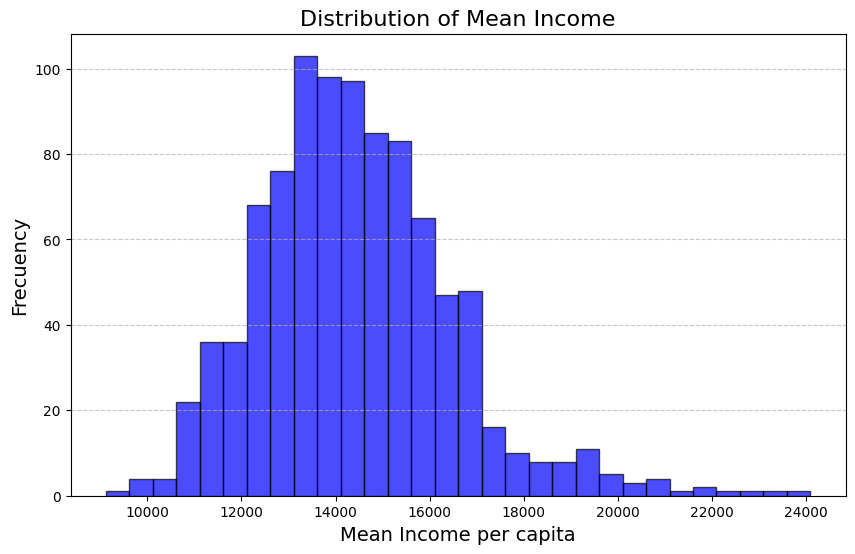

In [268]:
# Regla de Freedman-Diaconis

# Crear un histograma de la columna "Renta media por persona (€)"
plt.figure(figsize=(10, 6))
plt.hist(datos['Renta media por persona (€)'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribution of Mean Income", fontsize=16)
plt.xlabel("Mean Income per capita (€)", fontsize=14)
plt.ylabel("Frecuency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()


# Análisis datos Proporcion inmigrantes

In [40]:
# Verificar si hay valores iguales a cero en "Renta media por persona (€)"
valores_cero = datos[datos['prop no española'] == 0]

# Mostrar cuántos y cuáles son
print(f"\nNúmero de municipios con renta media igual a 0: {len(valores_cero)}")
print(valores_cero[['Codigo', 'Municipio', 'prop no española']])

print(datos['prop no española'].describe())


Número de municipios con renta media igual a 0: 9
    Codigo                Municipio  prop no española
105  08021                 Bellprat               0.0
186  08045                  Capolat               0.0
195  25904           Castell de Mur               0.0
331  08093               Gisclareny               0.0
394  25129                  Llobera               0.0
654  08195  Sant Agustí de Lluçanès               0.0
768  43143       Savallà del Comtat               0.0
772  43146                    Senan               0.0
818  25222                  Tiurana               0.0
count    946.000000
mean       0.103331
std        0.069585
min        0.000000
25%        0.054000
50%        0.090000
75%        0.137000
max        0.524000
Name: prop no española, dtype: float64


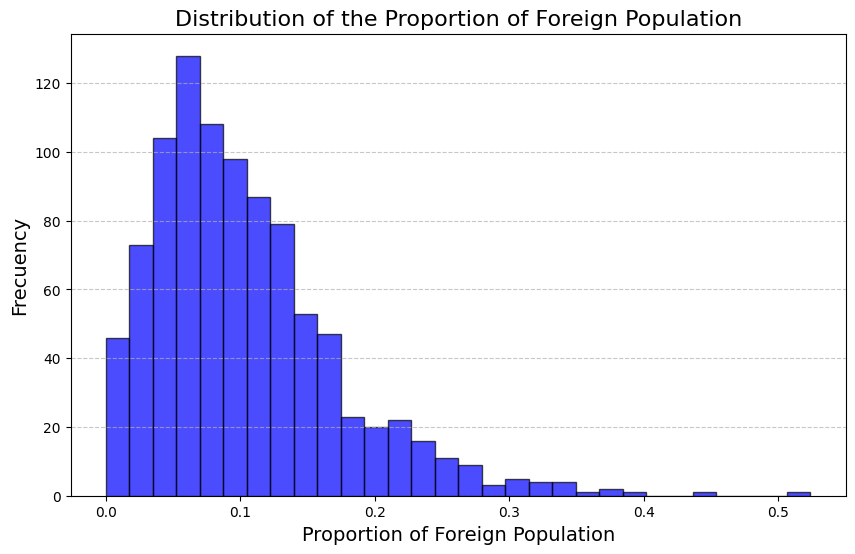

In [269]:
# Regla de Freedman-Diaconis

# Crear un histograma de la columna "Poporcion de poblacion no española"
plt.figure(figsize=(10, 6))
plt.hist(datos['prop no española'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribution of the Proportion of Foreign Population", fontsize=16)
plt.xlabel("Proportion of Foreign Population", fontsize=14)
plt.ylabel("Frecuency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

In [266]:
print(datos['prop no española'].describe())

count    946.000000
mean       0.103331
std        0.069585
min        0.000000
25%        0.054000
50%        0.090000
75%        0.137000
max        0.524000
Name: prop no española, dtype: float64


In [267]:
print(datos['Renta media por persona (€)'].describe())

count      945.000000
mean     14424.107937
std       2059.936062
min       9120.000000
25%      13052.000000
50%      14221.000000
75%      15578.000000
max      24091.000000
Name: Renta media por persona (€), dtype: float64


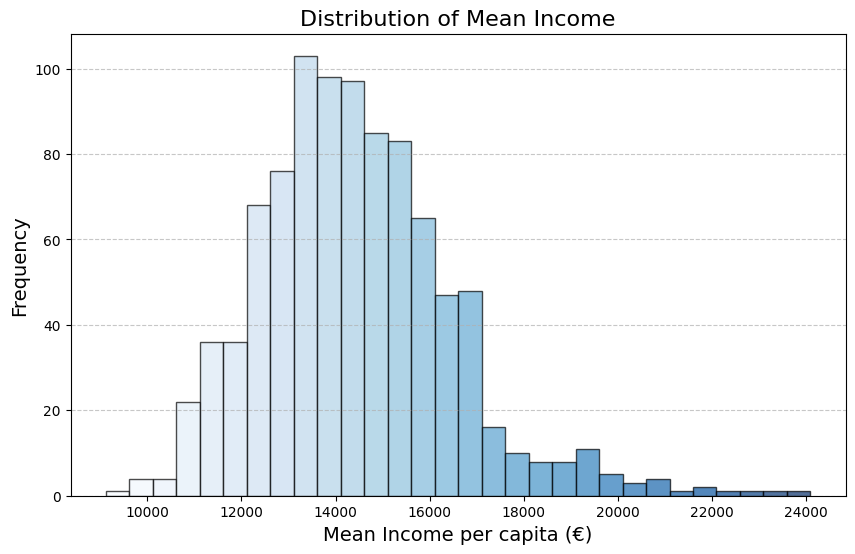

In [506]:
# Crear un histograma de "Renta media por persona (€)"
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(datos['Renta media por persona (€)'], bins=30, alpha=0.7, edgecolor='black')

# Aplicar colormap 'Blues'
cmap = plt.get_cmap('Blues')
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calcular los centros de cada bin
norm = plt.Normalize(bin_centers.min(), bin_centers.max())  # Normalizar según los valores de los datos y no las frecuencias

for patch, data in zip(patches, bin_centers):
    color = cmap(norm(data))  # Aplicar el color basado en la posición del centro del bin
    patch.set_facecolor(color)

# Personalizar el gráfico
plt.title("Distribution of Mean Income", fontsize=16)
plt.xlabel("Mean Income per capita (€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()


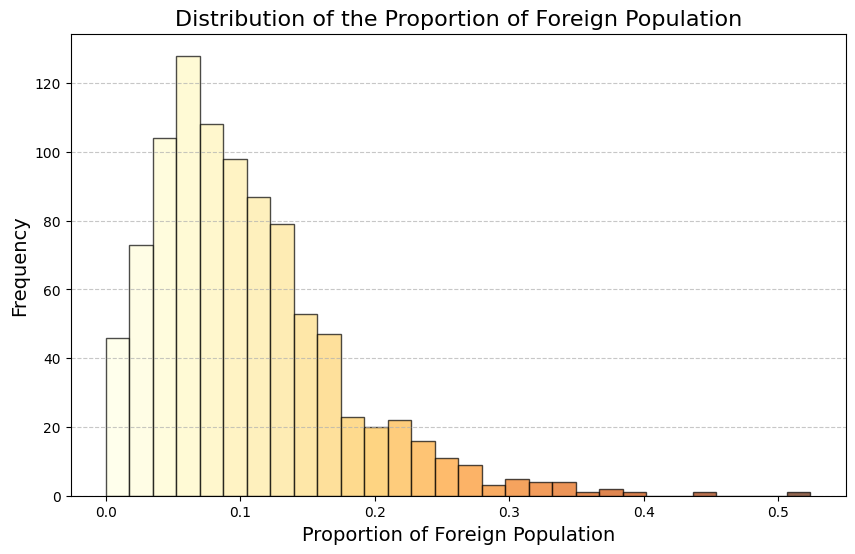

In [273]:
# Crear un histograma de "Proporción de población no española"
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(datos['prop no española'], bins=30, alpha=0.7, edgecolor='black')

# Aplicar colormap 'YlOrBr'
cmap = plt.get_cmap('YlOrBr')
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calcular los centros de cada bin
norm = plt.Normalize(bin_centers.min(), bin_centers.max())  # Normalizar según los valores de los datos y no las frecuencias

for patch, data in zip(patches, bin_centers):
    color = cmap(norm(data))  # Aplicar el color basado en la posición del centro del bin
    patch.set_facecolor(color)

# Personalizar el gráfico
plt.title("Distribution of the Proportion of Foreign Population", fontsize=16)
plt.xlabel("Proportion of Foreign Population", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()


# Incluir PR

In [507]:
# Calcular P como (proporción de inmigrantes - media) / desviación estándar
media_proporcion = datos['prop no española'].mean()
std_proporcion = datos['prop no española'].std()
datos['P'] = (datos['prop no española'] - media_proporcion) / std_proporcion

# Calcular R como (renta media - media de la renta media) / desviación estándar
media_renta = datos['Renta media por persona (€)'].mean()
std_renta = datos['Renta media por persona (€)'].std()
datos['R'] = (datos['Renta media por persona (€)'] - media_renta) / std_renta

# Calcular PR como el producto de P y R
datos['PR'] = datos['P'] * datos['R']

# Mostrar las  filas del DataFrame actualizado
datos[['Municipio', 'prop no española', 'P', 'R', 'PR']].head()



,Municipio,prop no española,P,R,PR
0,Abella de la Conca,NaN,NaN,-1.744767,NaN
1,Abrera,0.066,-0.536476,0.344618,-0.184880
2,Àger,0.124,0.297033,-0.095686,-0.028422
3,Agramunt,0.173,1.001205,-0.585993,-0.586699
4,Aguilar de Segarra,0.021,-1.183165,0.898519,-1.063096


In [508]:
print(datos['P'].describe())
print("\n" ,datos['R'].describe())

count    9.460000e+02
mean    -7.323247e-17
std      1.000000e+00
min     -1.484953e+00
25%     -7.089267e-01
50%     -1.915760e-01
75%      4.838542e-01
max      6.045375e+00
Name: P, dtype: float64

 count    9.450000e+02
mean    -1.278225e-16
std      1.000000e+00
min     -2.574890e+00
25%     -6.660925e-01
50%     -9.859915e-02
75%      5.601592e-01
max      4.692812e+00
Name: R, dtype: float64


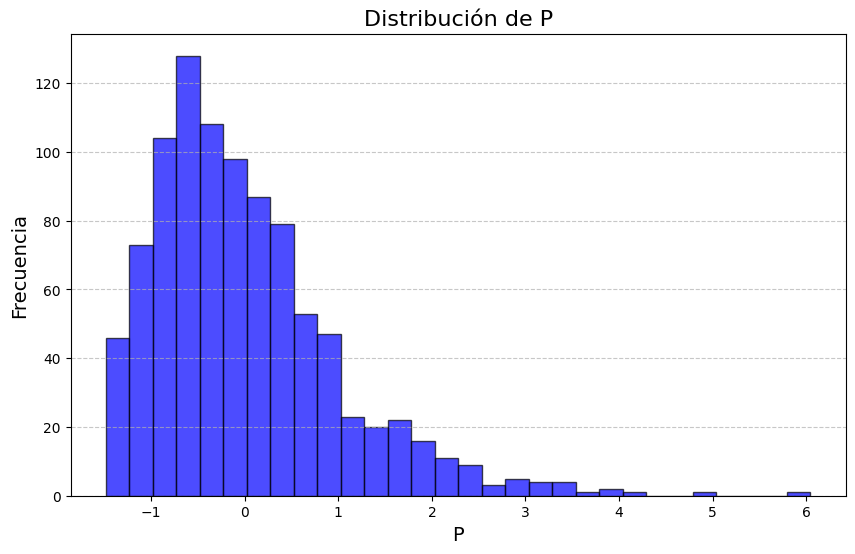

In [509]:
# Crear un histograma de la columna "P"
plt.figure(figsize=(10, 6))
plt.hist(datos['P'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribución de P", fontsize=16)
plt.xlabel("P", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

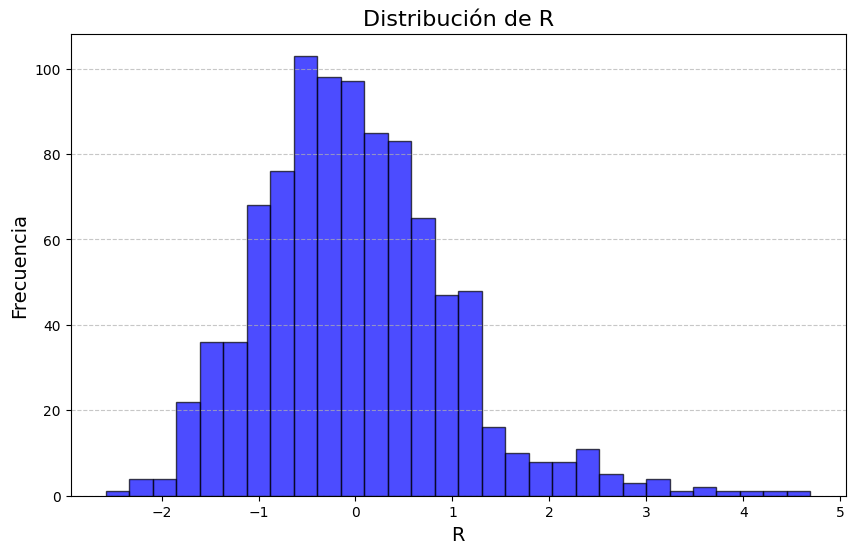

In [510]:
# Crear un histograma de la columna "R"
plt.figure(figsize=(10, 6))
plt.hist(datos['R'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribución de R", fontsize=16)
plt.xlabel("R", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

In [511]:
print(datos['PR'].describe())

count    944.000000
mean      -0.419025
std        1.022878
min       -8.876092
25%       -0.684748
50%       -0.156597
75%        0.047335
max        3.813922
Name: PR, dtype: float64


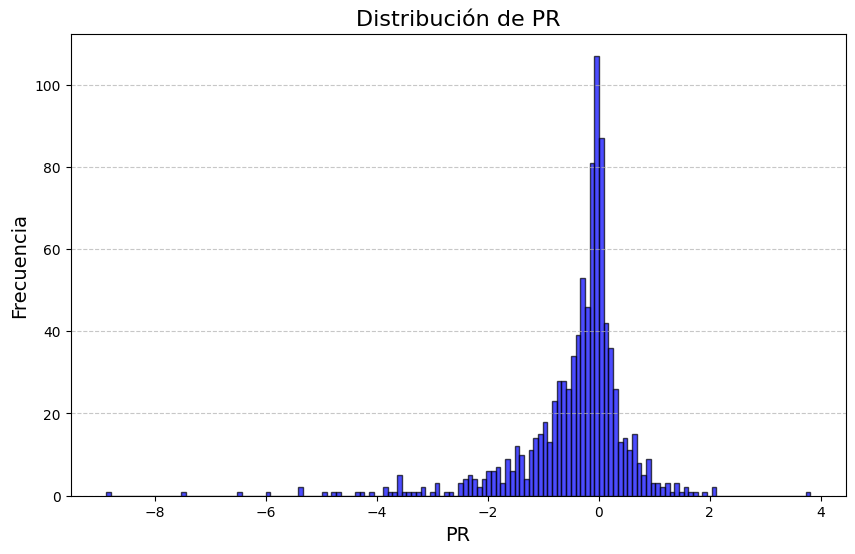

In [512]:
# Crear un histograma de la columna "PR"
plt.figure(figsize=(10, 6))
plt.hist(datos['PR'], bins=150, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribución de PR", fontsize=16)
plt.xlabel("PR", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

# Tree map

In [110]:
print(datos['Renta media por persona (€)'].describe())

count      945.000000
mean     14424.107937
std       2059.936062
min       9120.000000
25%      13052.000000
50%      14221.000000
75%      15578.000000
max      24091.000000
Name: Renta media por persona (€), dtype: float64


In [463]:
# Filtrar datos limpios eliminando filas con NaN en las columnas 'P' y 'R'
datos_limpios = datos.dropna(subset=['Renta media por persona (€)', 'prop no española']).reset_index(drop=True)

# Calcular los percentiles para los top 2% altos y bajos
top_pct_high_R = np.percentile(datos_limpios['Renta media por persona (€)'], 90)
top_pct_low_R = np.percentile(datos_limpios['Renta media por persona (€)'], 10)
median_rent = datos_limpios['Renta media por persona (€)'].median()

# Filtrar los datos
high_rent = datos_limpios[datos_limpios['Renta media por persona (€)'] >= top_pct_high_R]
median_rent_df = datos_limpios.iloc[(datos_limpios['Renta media por persona (€)'] - median_rent).abs().argsort()[:1]]
low_rent = datos_limpios[datos_limpios['Renta media por persona (€)'] <= top_pct_low_R]

# Concatenar en un DataFrame
tree_R = pd.concat([high_rent, median_rent_df, low_rent])

# Mostrar rangos y mediana
high_rent_range = (high_rent['Renta media por persona (€)'].min(), high_rent['Renta media por persona (€)'].max())
low_rent_range = (low_rent['Renta media por persona (€)'].min(), low_rent['Renta media por persona (€)'].max())
median_rent_value = median_rent_df['Renta media por persona (€)'].iloc[0]

print("Rango alto de renta media:", high_rent_range)
print("Valor mediano de renta media:", median_rent_value)
print("Rango bajo de renta media:", low_rent_range)

# Repetir el proceso para la columna 'prop no española'
top_pct_high_P = np.percentile(datos_limpios['prop no española'], 90)
top_pct_low_P = np.percentile(datos_limpios['prop no española'], 10)
median_prop = datos_limpios['prop no española'].median()

high_prop = datos_limpios[datos_limpios['prop no española'] >= top_pct_high_P]
median_prop_df = datos_limpios.iloc[(datos_limpios['prop no española'] - median_prop).abs().argsort()[:1]]
low_prop = datos_limpios[datos_limpios['prop no española'] <= top_pct_low_P]

tree_P = pd.concat([high_prop, median_prop_df, low_prop])

high_prop_range = (high_prop['prop no española'].min(), high_prop['prop no española'].max())
low_prop_range = (low_prop['prop no española'].min(), low_prop['prop no española'].max())
median_prop_value = median_prop_df['prop no española'].iloc[0]

print("Rango alto de proporción no española:", high_prop_range)
print("Valor mediano de proporción no española:", median_prop_value)
print("Rango bajo de proporción no española:", low_prop_range)

Rango alto de renta media: (16922.0, 24091.0)
Valor mediano de renta media: 14221.0
Rango bajo de renta media: (9120.0, 12069.0)
Rango alto de proporción no española: (0.196, 0.524)
Valor mediano de proporción no española: 0.09
Rango bajo de proporción no española: (0.0, 0.031)


In [464]:
# Ordenar tree_R de mayor a menor según la columna 'Renta media por persona (€)'
tree_R_sorted = tree_R.sort_values(by='Renta media por persona (€)', ascending=False)

# Ordenar tree_P de mayor a menor según la columna 'prop no española'
tree_P_sorted = tree_P.sort_values(by='prop no española', ascending=False)

tree_R_sorted.head()


,Codigo,Codigo_trunc,Municipio,Caracter,Renta media por persona (€),Extranjeros de países de renta baja o media (%),prop no española,P,R,PR,Color
428,08120,08120,Matadepera,2,24091.0,"1,5",0.032,-1.025086,4.692812,-4.810533,orange
360,17084,17084,Isòvol,3,23450.0,"1,3",0.029,-1.068198,4.381637,-4.680456,green
125,17024,17024,Bolvir,3,23036.0,"4,1",0.086,-0.249059,4.180660,-1.041233,green
700,08221,08221,Sant Just Desvern,1,22322.0,"5,2",0.114,0.153325,3.834047,0.587854,purple
666,08205,08205,Sant Cugat del Vallès,1,21888.0,"6,2",0.127,0.340146,3.623361,1.232471,purple


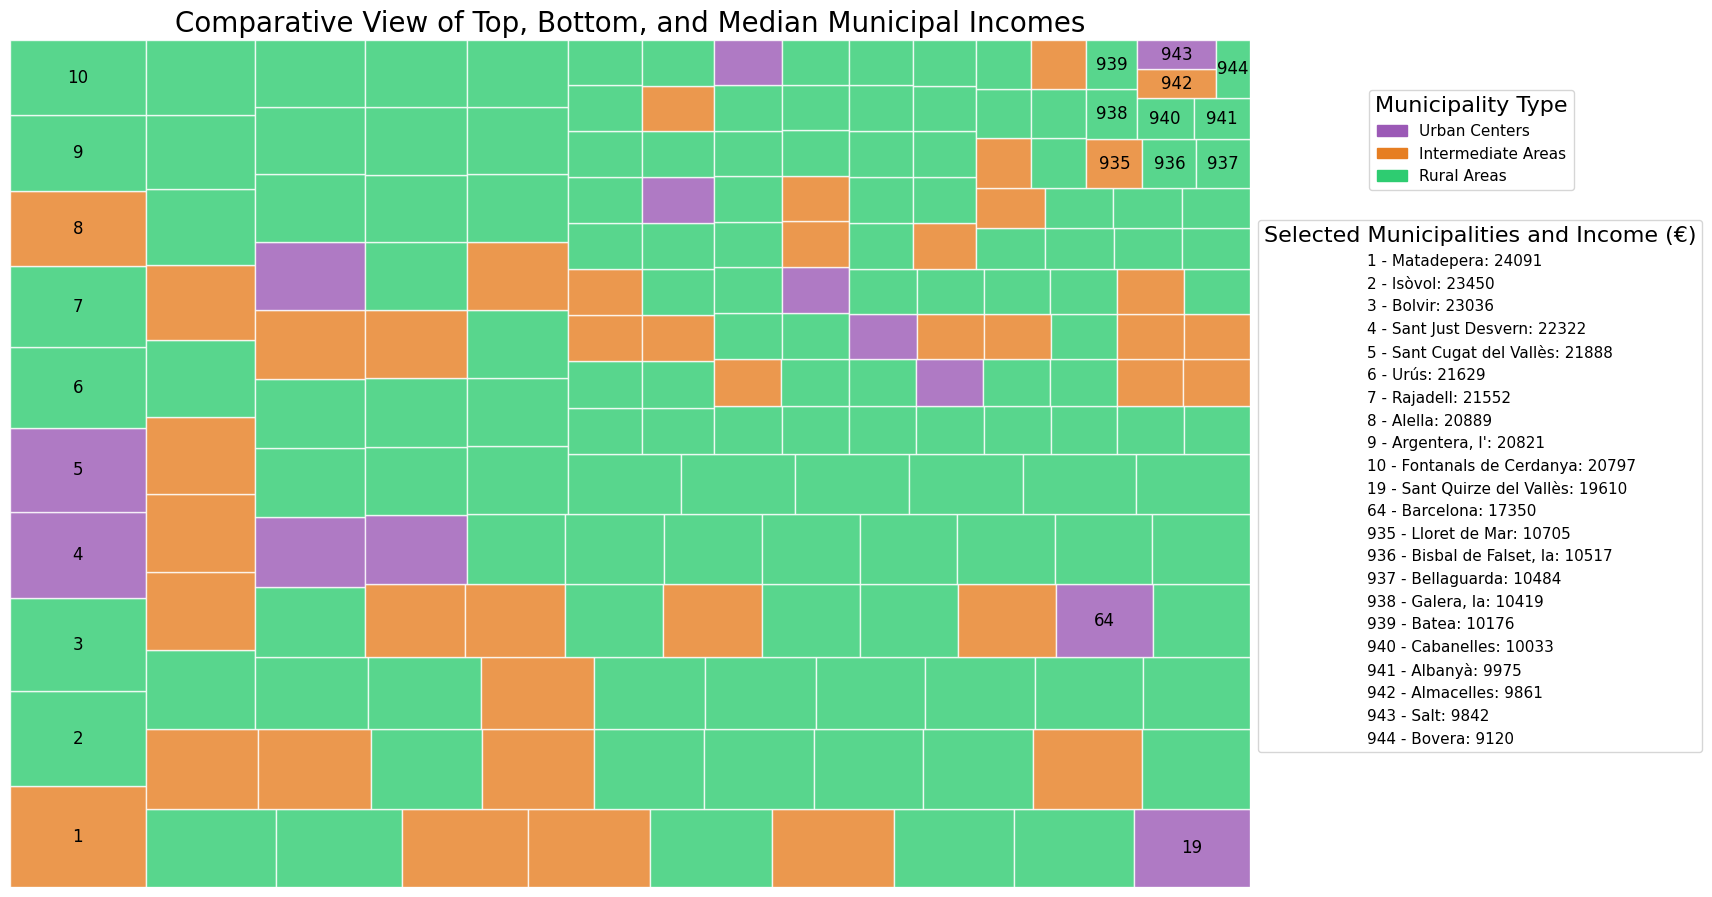

In [473]:
# Ordenar y calcular los puestos
datos_limpios.sort_values('Renta media por persona (€)', ascending=False, inplace=True)
datos_limpios['Puesto'] = range(1, len(datos_limpios) + 1)

# Calcular el número de registros para el top y bottom 10%
top_bottom_n = int(len(datos_limpios) * 0.10)

# Extraer top 10%, bottom 10% y el más cercano a la mediana
top_10_percent = datos_limpios.head(top_bottom_n)
bottom_10_percent = datos_limpios.tail(top_bottom_n)
median_muni = datos_limpios.iloc[[datos_limpios['Renta media por persona (€)'].sub(datos_limpios['Renta media por persona (€)'].median()).abs().idxmin()]]

# Unir los datos seleccionados para el treemap
selected_data = pd.concat([top_10_percent, bottom_10_percent, median_muni]).drop_duplicates()

# Filtrar ciudades importantes si están en los datos seleccionados
important_cities_names = ['Barcelona', 'Girona', 'Tarragona', 'Lleida']
important_cities = datos_limpios[datos_limpios['Municipio'].isin(important_cities_names) & datos_limpios.index.isin(selected_data.index)]

# Datos para la leyenda y etiquetas de los rectángulos
legend_data = pd.concat([top_10_percent.head(10), bottom_10_percent.tail(10), median_muni, important_cities]).drop_duplicates().sort_values(by='Puesto')

# Mapeo de colores y descripciones
color_mapping = {1: '#9b59b6', 2: '#e67e22', 3: '#2ecc71'}  # Morado, naranja, verde
character_descriptions = {1: "Urban Centers", 2: "Intermediate Areas", 3: "Rural Areas"}

# Transformación para los tamaños
sizes = selected_data['Renta media por persona (€)']**2
labels = [str(row['Puesto']) if row['Municipio'] in legend_data['Municipio'].values else '' for index, row in selected_data.iterrows()]
colors = selected_data['Caracter'].map(color_mapping)

# Crear el treemap
plt.figure(figsize=(16, 11))
ax = squarify.plot(sizes=sizes, label=labels, color=[color_mapping[x] for x in selected_data['Caracter']], alpha=0.8, edgecolor='white', linewidth=1, pad=0)

# Ajustar el tamaño de la fuente de las etiquetas
for text in ax.texts:
    text.set_fontsize(12)  # Cambiar a un tamaño más grande según necesario

# Leyenda para los colores
color_legend_handles = [mpatches.Patch(color=color, label=desc) for desc, color in zip(character_descriptions.values(), color_mapping.values())]
first_legend = plt.legend(handles=color_legend_handles, title="Municipality Type", loc='upper left',  bbox_to_anchor=(1.09, 0.95), ncol=1, fontsize=11)
first_legend.get_title().set_fontsize('16')

plt.gca().add_artist(first_legend)  # Asegurarse de que la primera leyenda permanezca cuando se añada la segunda
income_legend_handles = [mpatches.Patch(color='white', label=f"{row['Puesto']} - {row['Municipio']}: {int(row['Renta media por persona (€)'])}")
                          for index, row in legend_data.iterrows()]
second_legend = plt.legend(handles=income_legend_handles, title="Selected Municipalities and Income (€)", loc='lower left', bbox_to_anchor=(1, 0.15), ncol=1, fontsize=11)
second_legend.get_title().set_fontsize('16')  # Cambiar el tamaño de fuente del título de la segunda leyenda

# Título y ajustes de formato
plt.title('Comparative View of Top, Bottom, and Median Municipal Incomes', fontsize=20)
plt.axis('off')

# Mostrar el gráfico
plt.show()


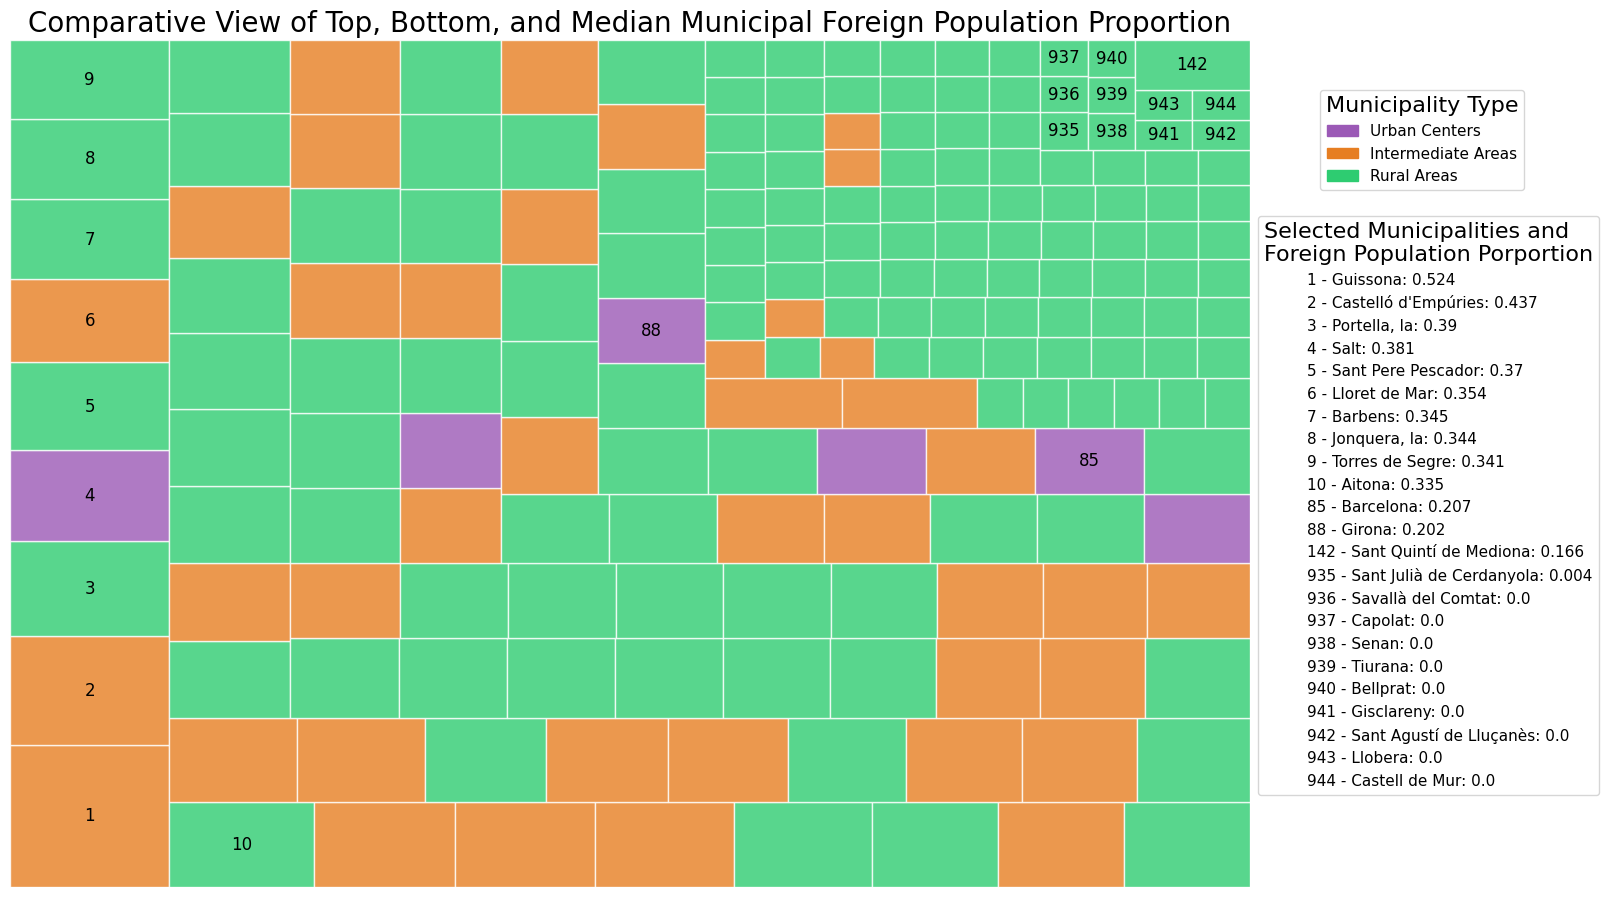

In [338]:
# Ordenar y calcular los puestos
datos_limpios.sort_values('prop no española', ascending=False, inplace=True)
datos_limpios['Puesto'] = range(1, len(datos_limpios) + 1)

# Calcular el número de registros para el top y bottom 10%
top_bottom_n = int(len(datos_limpios) * 0.10)

# Extraer top 10%, bottom 10% y el más cercano a la mediana
top_10_percent = datos_limpios.head(top_bottom_n)
bottom_10_percent = datos_limpios.tail(top_bottom_n)
median_muni = datos_limpios.iloc[[datos_limpios['prop no española'].sub(datos_limpios['prop no española'].median()).abs().idxmin()]]

# Unir los datos seleccionados para el treemap
selected_data = pd.concat([top_10_percent, bottom_10_percent, median_muni]).drop_duplicates()

# Filtrar ciudades importantes si están en los datos seleccionados
important_cities_names = ['Barcelona', 'Girona', 'Tarragona', 'Lleida']
important_cities = datos_limpios[datos_limpios['Municipio'].isin(important_cities_names) & datos_limpios.index.isin(selected_data.index)]

# Datos para la leyenda y etiquetas de los rectángulos
legend_data = pd.concat([top_10_percent.head(10), bottom_10_percent.tail(10), median_muni, important_cities]).drop_duplicates().sort_values(by='Puesto')

# Mapeo de colores y descripciones
color_mapping = {1: '#9b59b6', 2: '#e67e22', 3: '#2ecc71'}  # Morado, naranja, verde
character_descriptions = {1: "Urban Centers", 2: "Intermediate Areas", 3: "Rural Areas"}

# Transformación para los tamaños
sizes = (selected_data['prop no española']+0.2)**2
labels = [str(row['Puesto']) if row['Municipio'] in legend_data['Municipio'].values else '' for index, row in selected_data.iterrows()]
colors = selected_data['Caracter'].map(color_mapping)

# Crear el treemap
plt.figure(figsize=(16, 11))
ax = squarify.plot(sizes=sizes, label=labels, color=[color_mapping[x] for x in selected_data['Caracter']], alpha=0.8, edgecolor='white', linewidth=1, pad=0)

# Ajustar el tamaño de la fuente de las etiquetas
for text in ax.texts:
    text.set_fontsize(12)  # Cambiar a un tamaño más grande según necesario

# Leyenda para los colores
color_legend_handles = [mpatches.Patch(color=color, label=desc) for desc, color in zip(character_descriptions.values(), color_mapping.values())]
first_legend = plt.legend(handles=color_legend_handles, title="Municipality Type", loc='upper left', bbox_to_anchor=(1.05, 0.95), ncol=1, fontsize=11)
first_legend.get_title().set_fontsize('16')

plt.gca().add_artist(first_legend)  # Asegurarse de que la primera leyenda permanezca cuando se añada la segunda
income_legend_handles = [mpatches.Patch(color='white', label=f"{row['Puesto']} - {row['Municipio']}: {row['prop no española']}")
                          for index, row in legend_data.iterrows()]
second_legend = plt.legend(handles=income_legend_handles, title="Selected Municipalities and  \nForeign Population Porportion", loc='lower left', bbox_to_anchor=(1, 0.1), ncol=1, fontsize=11)
second_legend.get_title().set_fontsize('16')  # Cambiar el tamaño de fuente del título de la segunda leyenda

# Título y ajustes de formato
plt.title('Comparative View of Top, Bottom, and Median Municipal Foreign Population Proportion', fontsize=20)
plt.axis('off')

# Mostrar el gráfico
plt.show()


In [513]:
# Conteo de frecuencias de cada categoría en la columna 'Caracter'
character_counts = datos_limpios['Caracter'].value_counts()

# porcentajes
character_percentages = character_counts / character_counts.sum() * 100

print("Porcentaje de municipios por tipo de Caracter:")
print(character_percentages)

Porcentaje de municipios por tipo de Caracter:
Caracter
3    72.457627
2    22.563559
1     4.978814
Name: count, dtype: float64


# Scatter plot Correlacion

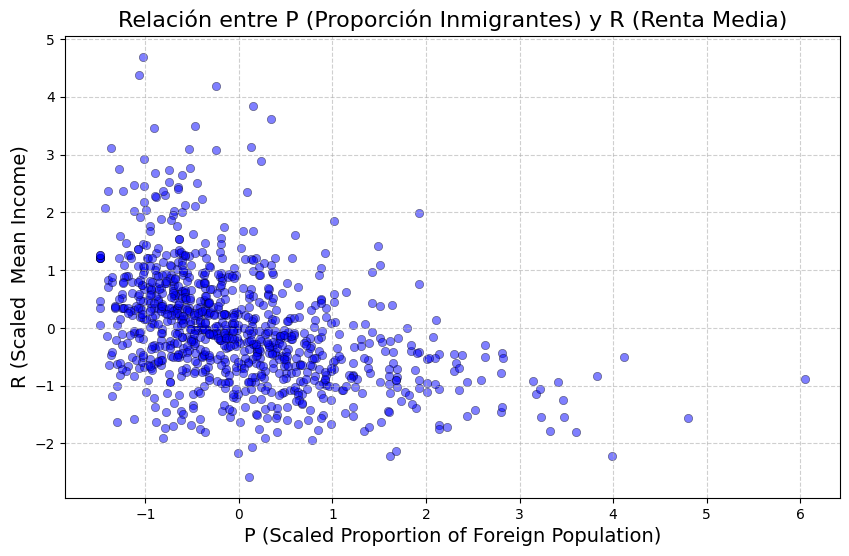

In [514]:
# Crear el scatterplot con seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=datos, x='P', y='R', alpha= 0.5 ,color='blue', edgecolor='black')

# Personalizar el gráfico
plt.title("Relación entre P (Proporción Inmigrantes) y R (Renta Media)", fontsize=16)
plt.xlabel("P (Scaled Proportion of Foreign Population)", fontsize=14)
plt.ylabel("R (Scaled  Mean Income)", fontsize=14)
plt.grid(linestyle='--', alpha=0.6)

# Mostrar el scatterplot
plt.show()


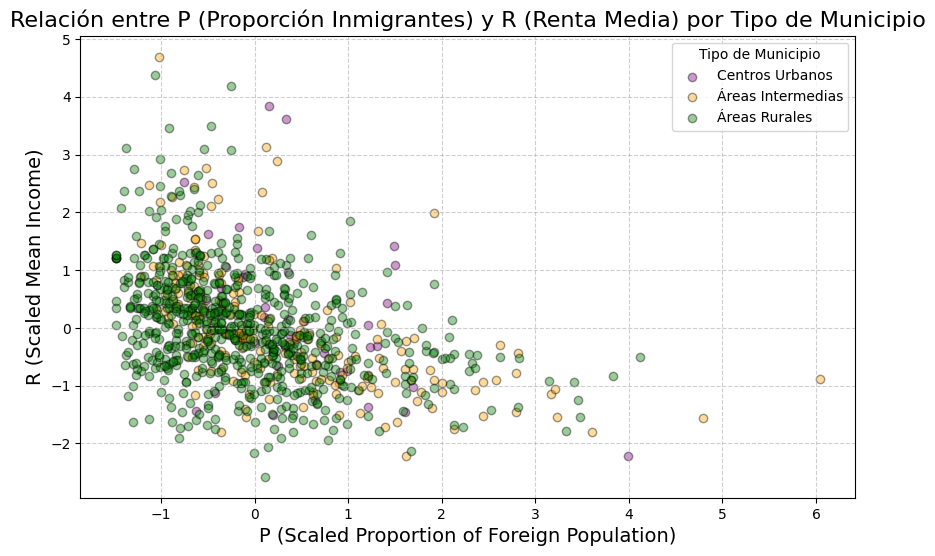

In [515]:
# Crear un diccionario para asignar colores según el tipo de municipio
colores_municipios = {
    1: 'purple',   # Urban Centers
    2: 'orange',   # Intermediate Areas
    3: 'green'     # Rural Areas
}

# Agregar una columna con los colores asociados al tipo de municipio
datos['Color'] = datos['Caracter'].map(colores_municipios)


plt.figure(figsize=(10, 6))
for caracter, color in colores_municipios.items():
    subset = datos[datos['Caracter'] == caracter]
    plt.scatter(subset['P'], subset['R'], color=color, label=f'Caracter {caracter}', alpha=0.4, edgecolor='black')

plt.title("Relación entre P (Proporción Inmigrantes) y R (Renta Media) por Tipo de Municipio", fontsize=16)
plt.xlabel("P (Scaled Proportion of Foreign Population)", fontsize=14)
plt.ylabel("R (Scaled Mean Income)", fontsize=14)
plt.grid(linestyle='--', alpha=0.6)
plt.legend(title="Tipo de Municipio", labels=["Centros Urbanos", "Áreas Intermedias", "Áreas Rurales"])

#g = sns.FacetGrid(datos, col="Caracter", hue="Caracter", palette=colores_municipios, height=6)
#g.map(sns.scatterplot, "P", "R", alpha=0.6, edgecolor='black')
#g.add_legend(title="Tipo de Municipio", labels=["Centros Urbanos", "Áreas Intermedias", "Áreas Rurales"])
#g.set_titles("Tipo de Municipio: {col_name}")


# Mostrar el scatterplot
plt.show()


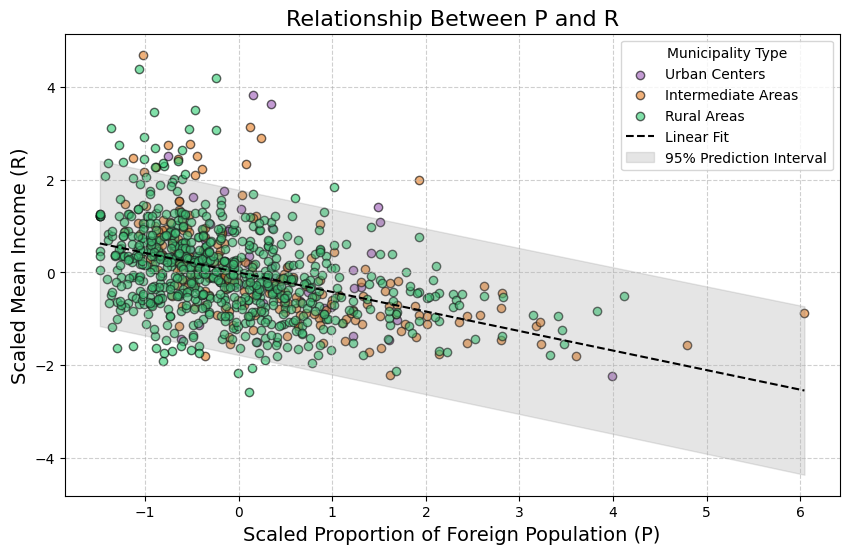

=== Regresión Lineal ===
Pendiente (slope): -0.4210 ± 0.0296
Intercepto: 0.0006
Coeficiente de determinación (R^2): 0.1770


In [389]:
# Filtrar datos limpios eliminando filas con NaN 
datos_limpios = datos.dropna(subset=['Renta media por persona (€)', 'prop no española']).reset_index(drop=True)

# Define colors and descriptions for municipality types
color_mapping = {
    1: '#9b59b6',  # Purple - Urban Centers
    2: '#e67e22',  # Orange - Intermediate Areas
    3: '#2ecc71'   # Green - Rural Areas
}
character_descriptions = {
    1: "Urban Centers",
    2: "Intermediate Areas",
    3: "Rural Areas"
}

# Assign colors based on municipality type
datos_limpios['Color'] = datos_limpios['Caracter'].map(color_mapping)

# Create a scatter plot with color coding by municipality type
plt.figure(figsize=(10, 6))
for caracter, color in color_mapping.items():
    subset = datos_limpios[datos_limpios['Caracter'] == caracter]
    plt.scatter(subset['P'], subset['R'], color=color, label=f'{character_descriptions[caracter]}', alpha=0.6, edgecolor='black')

# Linear regression and prediction interval calculation
x = datos_limpios['P']
y = datos_limpios['R']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
P_line = np.linspace(np.min(x), np.max(x), 100)
R_line = intercept + slope * P_line
# Calculate prediction band
pred_error = y - (intercept + slope * x)
alpha = 0.05  # 95% confidence interval
t = stats.t.ppf(1 - alpha/2, df=len(x)-2)
sd_pred = np.sqrt(np.sum(pred_error**2) / (len(x) - 2))
conf_band = t * sd_pred * np.sqrt(1 + 1/len(x) + (P_line - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Add linear fit and prediction band to the plot
plt.plot(P_line, R_line, color='black', linestyle='--', label='Linear Fit')
plt.fill_between(P_line, R_line - conf_band, R_line + conf_band, color='grey', alpha=0.2, label='95% Prediction Interval')

# Customize the chart
plt.title("Relationship Between P and R", fontsize=16)
plt.xlabel("Scaled Proportion of Foreign Population (P)", fontsize=14)
plt.ylabel("Scaled Mean Income (R)", fontsize=14)
plt.grid(linestyle='--', alpha=0.6)
plt.legend(title="Municipality Type")

# Show the plot
plt.show()

# Métricas de bondad del ajuste y parámetros
print("Regresión Lineal")
print(f"Pendiente (slope): {slope:.4f} ± {std_err:.4f}")
print(f"Intercepto: {intercept:.4f}")
print(f"Coeficiente de determinación (R^2): {r_value**2:.4f}")


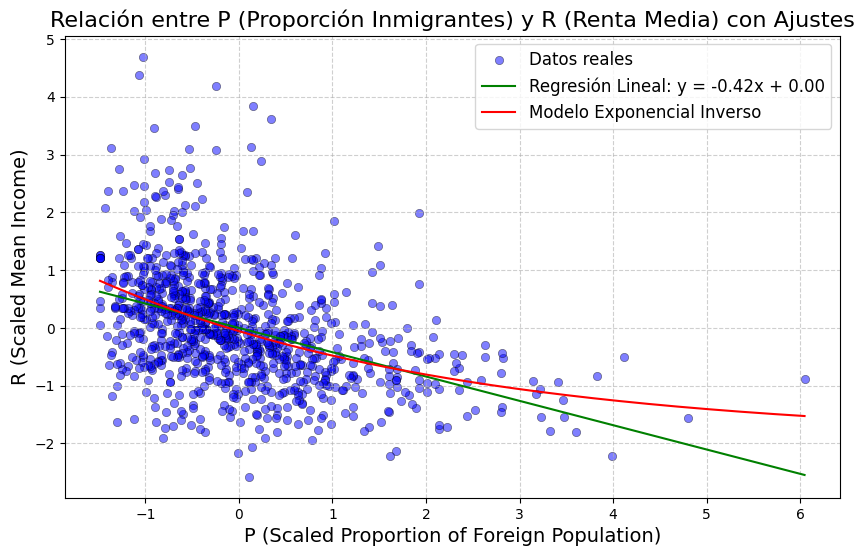

=== Regresión Lineal ===
Pendiente (slope): -0.4210 ± 0.0296
Intercepto: 0.0006
Coeficiente de determinación (R^2): 0.1770

=== Modelo Exponencial Inverso ===
Parámetros: a = 1.8557 ± 0.7152, b = 0.2592 ± 0.1044, c = -1.9119 ± 0.6944


In [367]:
# Ajustar regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(datos_limpios['P'], datos_limpios['R'])

# Modelo exponencial inverso: R(P) = a * exp(-b * P) + c
def modelo_exp(P, a, b, c):
    return a * np.exp(-b * P) + c

# Ajustar el modelo exponencial inverso
P = datos_limpios['P'].values
R = datos_limpios['R'].values
param_exp, cov_exp = curve_fit(modelo_exp, P, R)
errors_exp = np.sqrt(np.diag(cov_exp))

# Generar puntos para las curvas ajustadas
P_curve = np.linspace(min(P), max(P), 500)
R_linear = slope * P_curve + intercept
R_exp = modelo_exp(P_curve, *param_exp)

# Crear el scatterplot con las funciones ajustadas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=datos_limpios, x='P', y='R', alpha=0.5, color='blue', edgecolor='black', label='Datos reales')
plt.plot(P_curve, R_linear, color='green', label=f'Regresión Lineal: y = {slope:.2f}x + {intercept:.2f}')
plt.plot(P_curve, R_exp, color='red', label='Modelo Exponencial Inverso')

# Personalizar el gráfico
plt.title("Relación entre P (Proporción Inmigrantes) y R (Renta Media) con Ajustes", fontsize=16)
plt.xlabel("P (Scaled Proportion of Foreign Population)", fontsize=14)
plt.ylabel("R (Scaled Mean Income)", fontsize=14)
plt.grid(linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Mostrar el scatterplot
plt.show()

# Métricas de bondad del ajuste y parámetros
print("=== Regresión Lineal ===")
print(f"Pendiente (slope): {slope:.4f} ± {std_err:.4f}")
print(f"Intercepto: {intercept:.4f}")
print(f"Coeficiente de determinación (R^2): {r_value**2:.4f}")

print("\n=== Modelo Exponencial Inverso ===")
print(f"Parámetros: a = {param_exp[0]:.4f} ± {errors_exp[0]:.4f}, "
      f"b = {param_exp[1]:.4f} ± {errors_exp[1]:.4f}, "
      f"c = {param_exp[2]:.4f} ± {errors_exp[2]:.4f}")


=== Regresión Lineal ===
Pendiente (slope): -0.5469 ± 0.2025
Intercepto: 0.3570
Coeficiente de determinación (R^2): 0.1395
=== Regresión Lineal ===
Pendiente (slope): -0.5210 ± 0.0527
Intercepto: 0.1321
Coeficiente de determinación (R^2): 0.3169
=== Regresión Lineal ===
Pendiente (slope): -0.3953 ± 0.0365
Intercepto: -0.0493
Coeficiente de determinación (R^2): 0.1465


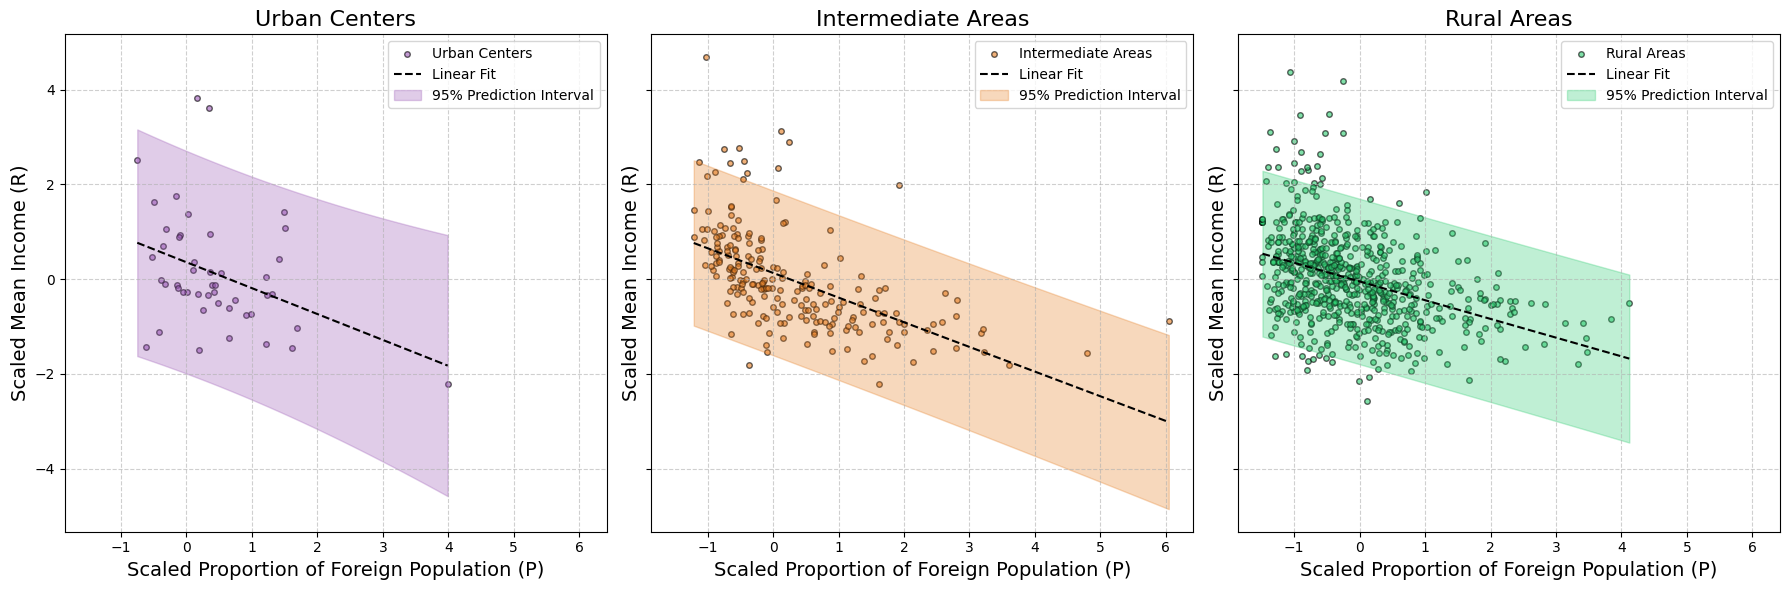

In [396]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy import stats

# Define colors and descriptions for municipality types
color_mapping = {
    1: '#9b59b6',  # Purple - Urban Centers
    2: '#e67e22',  # Orange - Intermediate Areas
    3: '#2ecc71'   # Green - Rural Areas
}
character_descriptions = {
    1: "Urban Centers",
    2: "Intermediate Areas",
    3: "Rural Areas"
}

# Assign colors based on municipality type
datos_limpios['Color'] = datos_limpios['Caracter'].map(color_mapping)

# Create individual scatter plots for each municipality type
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for index, caracter in enumerate(color_mapping.keys(), start=0):
    subset = datos_limpios[datos_limpios['Caracter'] == caracter]
    axs[index].scatter(subset['P'], subset['R'], color=color_mapping[caracter], s=16 ,label=f'{character_descriptions[caracter]}', alpha=0.6, edgecolor='black')

    # Linear regression for each category
    slope, intercept, r_value, p_value, std_err = linregress(subset['P'], subset['R'])
    P_line = np.linspace(np.min(subset['P']), np.max(subset['P']), 100)
    R_line = intercept + slope * P_line

    # Prediction interval calculation
    pred_error = subset['R'] - (intercept + slope * subset['P'])
    alpha = 0.05  # 95% confidence interval
    t = stats.t.ppf(1 - alpha/2, df=len(subset['P'])-2)
    sd_pred = np.sqrt(np.sum(pred_error**2) / (len(subset['P']) - 2))
    conf_band = t * sd_pred * np.sqrt(1 + 1/len(subset['P']) + (P_line - np.mean(subset['P']))**2 / np.sum((subset['P'] - np.mean(subset['P']))**2))

    axs[index].plot(P_line, R_line, color='black', linestyle='--', label='Linear Fit')
    axs[index].fill_between(P_line, R_line - conf_band, R_line + conf_band, color=color_mapping[caracter], alpha=0.3, label='95% Prediction Interval')

    axs[index].set_title(f"{character_descriptions[caracter]}", fontsize=16)
    axs[index].set_xlabel("Scaled Proportion of Foreign Population (P)", fontsize=14)
    axs[index].set_ylabel("Scaled Mean Income (R)", fontsize=14)
    axs[index].grid(linestyle='--', alpha=0.6)
    axs[index].legend()

    # Métricas de bondad del ajuste y parámetros
    print("=== Regresión Lineal ===")
    print(f"Pendiente (slope): {slope:.4f} ± {std_err:.4f}")
    print(f"Intercepto: {intercept:.4f}")
    print(f"Coeficiente de determinación (R^2): {r_value**2:.4f}")

# Show the plots
plt.tight_layout()
plt.show()


#  Merge entre todos los datos y municipios

In [399]:
merge3 = municipios.merge(
    datos,
    left_on='CODIMUNI_trunc',  # Clave en municipios
    right_on='Codigo_trunc',  # Clave en datos2
    how='left'  # Mantener todos los municipios (incluso si no hay datos en poblacion_inmigrantes)
)

merge3.columns

Index(['CODIMUNI', 'NOMMUNI', 'CAPMUNI', 'AREAM5000', 'CODICOMAR', 'NOMCOMAR',
       'CAPCOMAR', 'CODIVEGUE', 'NOMVEGUE', 'CAPVEGUE', 'CODIPROV', 'NOMPROV',
       'CAPPROV', 'geometry', 'CODIMUNI_trunc', 'Codigo', 'Codigo_trunc',
       'Municipio', 'Caracter', 'Renta media por persona (€)',
       'Extranjeros de países de renta baja o media (%)', 'prop no española',
       'P', 'R', 'PR', 'Color'],
      dtype='object')

# Mapa correlacion local

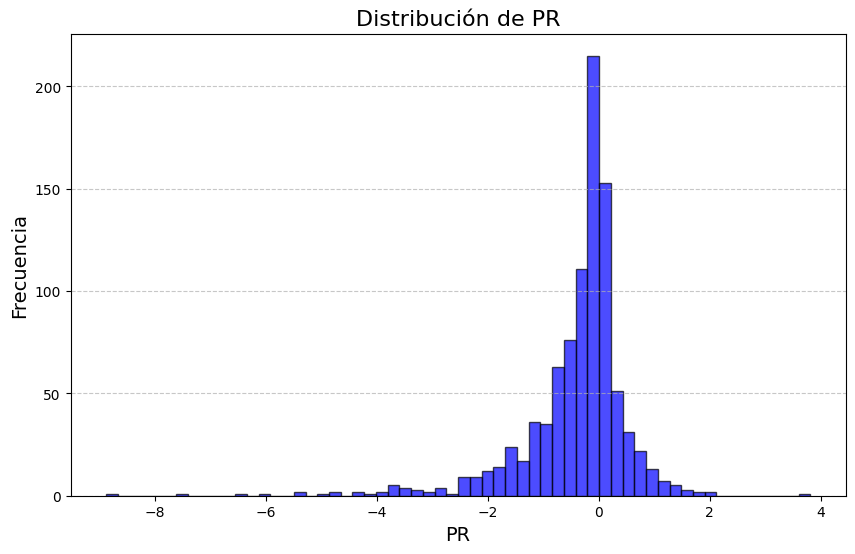

In [517]:
# Crear un histograma de la columna "PR"
plt.figure(figsize=(10, 6))
plt.hist(gdf['PR'], bins=60, color='blue', alpha=0.7, edgecolor='black')

# Personalizar el gráfico
plt.title("Distribución de PR", fontsize=16)
plt.xlabel("PR", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

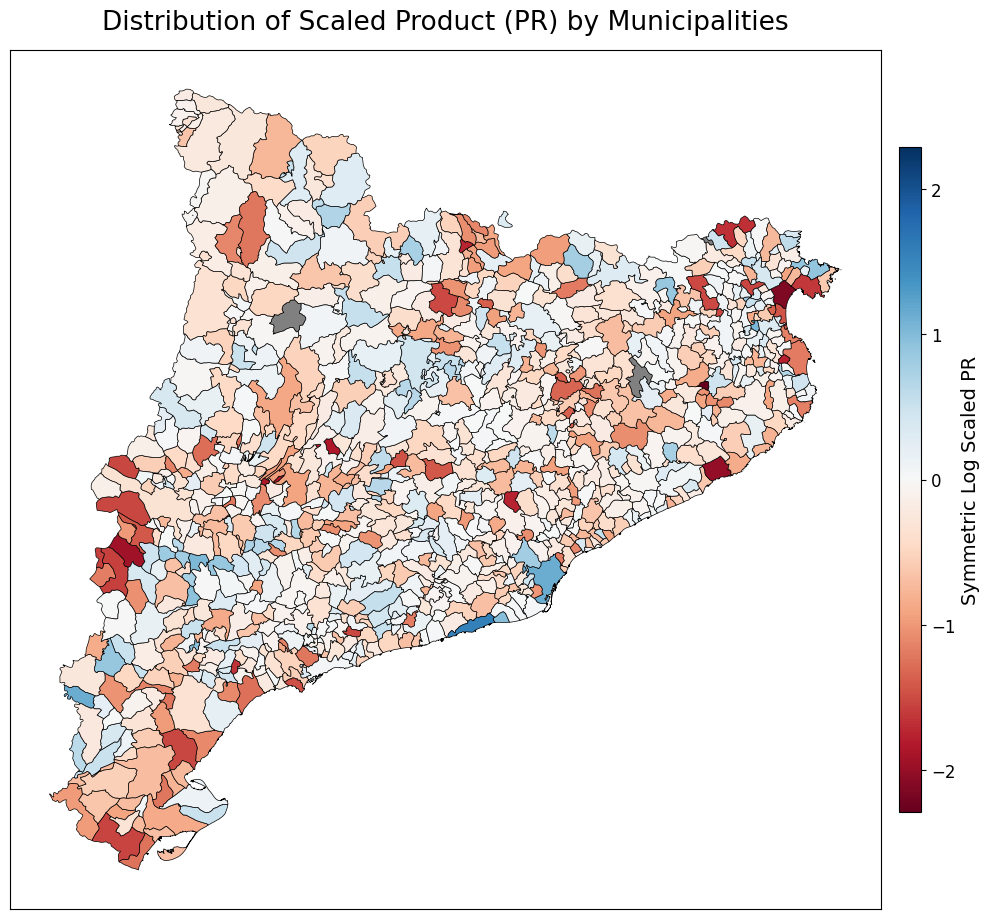

In [518]:
# Load your data
gdf = merge3  # assuming merge3 is already a GeoDataFrame

# Applying symmetric log transformation
gdf['PR_log'] = np.sign(gdf['PR']) * np.log1p(np.abs(gdf['PR']))

# Determine the maximum absolute value for symmetrical color mapping
vmax = np.nanmax(np.abs(gdf['PR_log']))
vmin = -vmax

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot municipalities with NaN values in PR
gdf[gdf['PR_log'].isna()].plot(
    color='grey',
    linewidth=0.5,
    edgecolor='black',
    ax=ax
)

# Plot municipalities with valid PR values using a symmetrical color scale
gdf[~gdf['PR_log'].isna()].plot(
    column='PR_log',
    cmap='RdBu',  # Red-Blue symmetric colormap
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax,
    vmin=vmin,  # Minimum value for color scale
    vmax=vmax,  # Maximum value for color scale
    legend_kwds={
        'label': "Symmetric Log Scaled PR",
        'shrink': 0.7,
        'orientation': 'vertical',
        'fraction': 0.03,
        'pad': 0.02,
        'aspect': 30
    }
)

# Adjust the font size of the color bar's legend
cbar = ax.get_figure().get_axes()[-1]  # Access the last axis object, which is the colorbar
cbar.set_ylabel('Symmetric Log Scaled PR', size=14)
cbar.tick_params(labelsize=12)

# Add title
ax.set_title("Distribution of Scaled Product (PR) by Municipalities", fontsize=19, pad=15)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


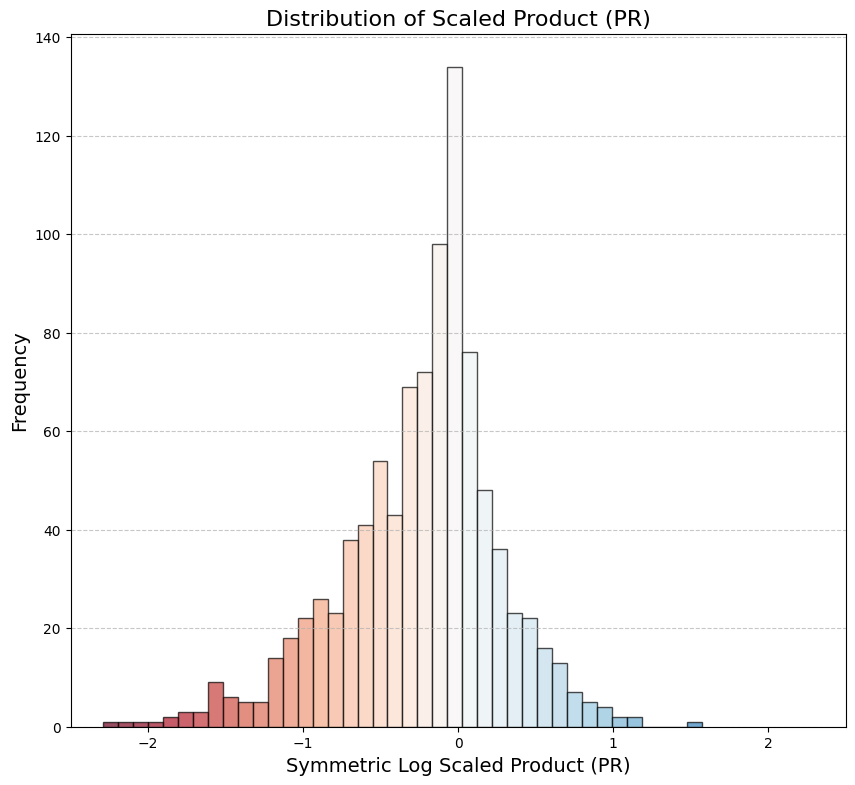

In [519]:
plt.figure(figsize=(10, 9))
n, bins, patches = plt.hist(gdf['PR_log'], bins=40, alpha=0.7, edgecolor='black')

# Calcular el valor máximo absoluto para centrar el colormap
vmax = np.max(np.abs(gdf['PR_log']))

# Crear un colormap centrado en cero
cmap = plt.get_cmap('RdBu')  # Usa 'RdBu' o 'coolwarm' que son simétricos
norm = plt.Normalize(-vmax, vmax)  # Centrar el colormap para que el cero sea el valor neutral

# Aplicar el colormap
for patch, data in zip(patches, 0.5 * (bins[:-1] + bins[1:])):
    color = cmap(norm(data))  # Aplicar el color basado en el valor normalizado
    patch.set_facecolor(color)

# Personalizar el gráfico
plt.title("Distribution of Scaled Product (PR)", fontsize=16)
plt.xlabel("Symmetric Log Scaled Product (PR)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim([-2.5,2.5])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el histograma
plt.show()

# Diagrama de sectores

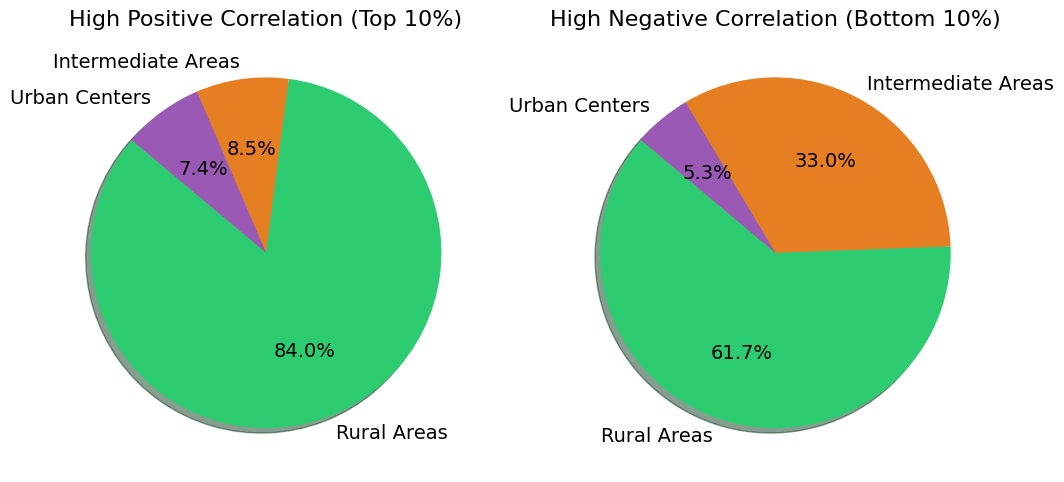

In [521]:
def plot_pie_chart(data, title, ax):
    # Contar la frecuencia de cada 'Caracter'
    type_counts = data['Caracter'].value_counts(normalize=True) * 100
    colors = ['#9b59b6', '#e67e22', '#2ecc71']  # Purple, orange, green
    labels = ['Urban Centers', 'Intermediate Areas', 'Rural Areas']
    # Ensure colors and labels match 'Caracter' indices
    labels = [labels[i-1] for i in type_counts.index]
    colors = [colors[i-1] for i in type_counts.index]
    
    # Create the pie chart
    wedges, texts, autotexts = ax.pie(type_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True, textprops={'fontsize': 14})
    ax.set_title(title, fontsize=16)

# Preparing figures and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Top 10% of positive correlations
top_10 = datos_limpios.nlargest(int(len(datos_limpios) * 0.1), 'PR_log')
plot_pie_chart(top_10, 'High Positive Correlation (Top 10%)', ax1)

# Bottom 10% of negative correlations
bottom_10 = datos_limpios.nsmallest(int(len(datos_limpios) * 0.1), 'PR_log')
plot_pie_chart(bottom_10, 'High Negative Correlation (Bottom 10%)', ax2)

# Show the plot
plt.tight_layout()
plt.show()
